"There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions."

In [285]:
!pip install gym
!git clone https://github.com/FlemingDL/gym_fleming.git
!pip install -e gym_fleming

You should consider upgrading via the 'pip install --upgrade pip' command.
fatal: destination path 'gym_fleming' already exists and is not an empty directory.
Obtaining file:///Users/rajivvenkataraman/Documents/MMAI/MMAI%20845/Final%20Project/gym_fleming
  Found existing installation: gym-fleming 0.0.2
    Uninstalling gym-fleming-0.0.2:
      Successfully uninstalled gym-fleming-0.0.2
  Running setup.py develop for gym-fleming
You should consider upgrading via the 'pip install --upgrade pip' command.


#### Import either one of environments below

In [209]:
import gym
import torch
import matplotlib.pyplot as plt
env = gym.make("Taxi-v3")

In [267]:
import gym
import gym_fleming
import torch
import matplotlib.pyplot as plt
env = gym.make('taxi_fleming-15x15-v0')

#### Renders one frame of the environment

In [268]:
env.render()

+-----------------------------+
|R: | : : : : | : : : : | : :G|
| : | : : : : | : : : : | : : |
| : : : : : : : : : : : : : : |
| | : | : : | : | : : | : | : |
| | : | : : | : | : : | : | : |
| : | : : : : | : : : : | : : |
| : | : : : : | : : : : | : : |
| : : : : : : : : : : : : : : |
| | : | : : | : | : : | : | : |
| | : | : : | : | : : | : | : |
| : | : : : : | : : : : | : : |
| : | : : : : | : : : : | : : |
| : : : : : : : : : : : : : : |
| | : | : : | : | : : | : | : |
|Y| : | : : | : | : : | : |B: |
+-----------------------------+



In [269]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(6)
State Space Discrete(4500)


In [270]:
state = env.encode(3, 3, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 968
+-----------------------------+
|R: | : : : : | : : : : | : :G|
| : | : : : : | : : : : | : : |
| : : : : : : : : : : : : : : |
| | : | : : | : | : : | : | : |
| | : | : : | : | : : | : | : |
| : | : : : : | : : : : | : : |
| : | : : : : | : : : : | : : |
| : : : : : : : : : : : : : : |
| | : | : : | : | : : | : | : |
| | : | : : | : | : : | : | : |
| : | : : : : | : : : : | : : |
| : | : : : : | : : : : | : : |
| : : : : : : : : : : : : : : |
| | : | : : | : | : : | : | : |
|Y| : | : : | : | : : | : |B: |
+-----------------------------+



In [271]:
env.P[368]

{0: [(1.0, 668, -1, False)],
 1: [(1.0, 68, -1, False)],
 2: [(1.0, 388, -1, False)],
 3: [(1.0, 348, -1, False)],
 4: [(1.0, 368, -10, False)],
 5: [(1.0, 368, -10, False)]}

**Solving the environment without Reinforcement Learning**

In [272]:
env.reset()
#env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 22205
Penalties incurred: 7282


In [215]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.9)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Timestep: 10
State: 81
Action: 1
Reward: -1


KeyboardInterrupt: 

**Defining the Epsilon-Greedy behaviour**

In [273]:
def gen_epsilon_greedy_policy(n_action, epsilon):
    def policy_function(state, Q):
          probs = torch.ones(n_action) * epsilon / n_action
          best_action = torch.argmax(Q[state]).item()
          probs[best_action] += 1.0 - epsilon
          action = torch.multinomial(probs, 1).item()
          return action
    return policy_function

#### 1. Specify number of episodes
#### 2. Initialize 2 variables tracking length and reward for each episode

In [274]:
n_episode = 2000
length_episode_SARSA = [0] * n_episode
total_reward_episode_SARSA = [0] * n_episode

In [275]:
from collections import defaultdict

def sarsa(env, gamma, n_episode, alpha):

     n_action = env.action_space.n
     Q = defaultdict(lambda: torch.zeros(n_action))
     frames =[]
     for episode in range(n_episode):
         state = env.reset()
         is_done = False
         action = epsilon_greedy_policy(state, Q)
         while not is_done:
             next_state, reward, is_done, info  = env.step(action)
                                   
             next_action = epsilon_greedy_policy(next_state, Q)
             td_delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
                                                
             Q[state][action] += alpha * td_delta
             length_episode_SARSA[episode] += 1
             total_reward_episode_SARSA[episode] += reward
             frames.append({
                      'frame': env.render(mode='ansi'),
                      'state': state,
                      'action': action,
                      'reward': reward
                            }
                            )
             if is_done:
                 break
             state = next_state
             action = next_action
     policy = {}
     for state, actions in Q.items():
         policy[state] = torch.argmax(actions).item()
     return Q, policy,frames

#### Setting default hyperparameters for now 

In [276]:
gamma = 1
alpha = 0.4
epsilon = 0.1

#### Call on Epsilon-Greedy function to create an instance of the policy

In [277]:
epsilon_greedy_policy = gen_epsilon_greedy_policy(env.action_space.n, epsilon)

#### Call on SARSA function with defined hyperparameters - returning Q-Function and Policy

In [278]:
%%time
optimal_Q, optimal_policy, frames = sarsa(env, gamma, n_episode, alpha)

CPU times: user 3min 18s, sys: 1.07 s, total: 3min 19s
Wall time: 3min 19s


#### Tracks the Length of each episode

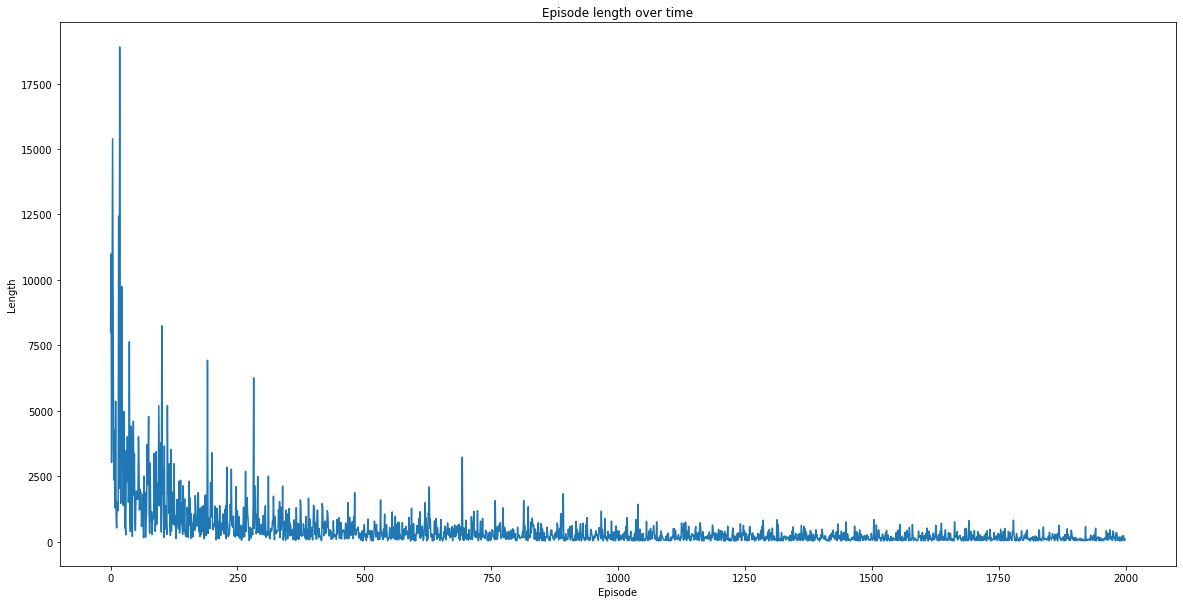

In [279]:
plt.figure(figsize=(20,10))
plt.plot(length_episode_SARSA)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.show()

#### Tracks the Total Rewards of each episode

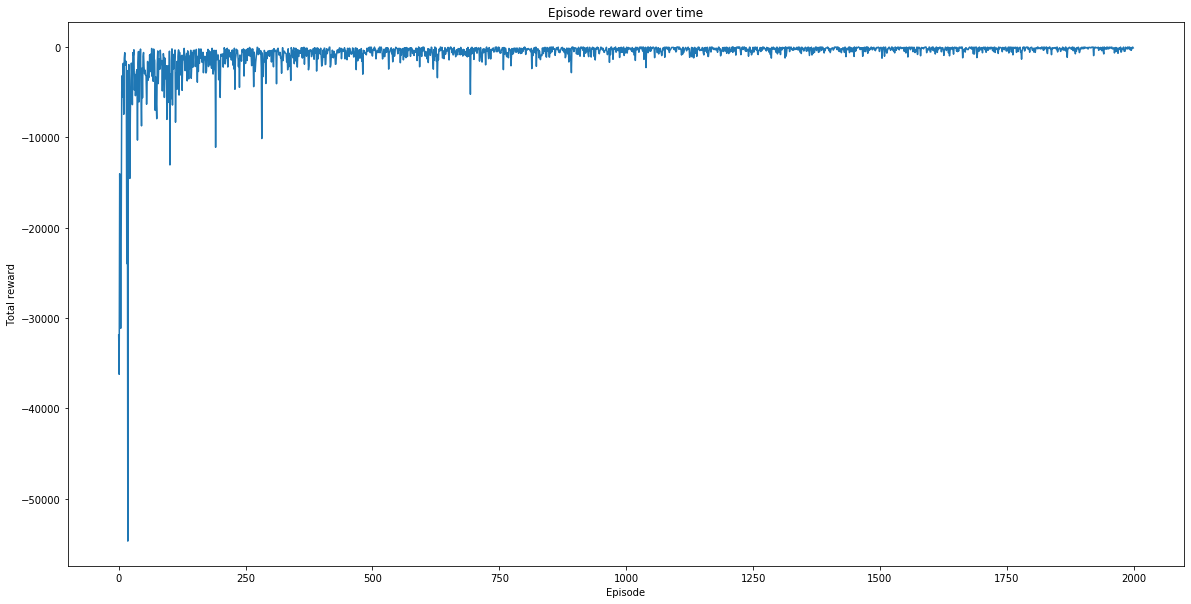

In [280]:
plt.figure(figsize=(20,10))
plt.plot(total_reward_episode_SARSA)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

In [281]:
total_reward_episode_SARSA[:1000]

[-31911,
 -36239,
 -14044,
 -20192,
 -31144,
 -20193,
 -4999,
 -3170,
 -5557,
 -1814,
 -7457,
 -1259,
 -634,
 -2005,
 -1580,
 -1654,
 -23986,
 -2619,
 -54699,
 -5459,
 -1954,
 -5313,
 -14553,
 -7344,
 -3709,
 -1791,
 -3106,
 -6392,
 -634,
 -931,
 -315,
 -4792,
 -3026,
 -5397,
 -4411,
 -2765,
 -2516,
 -10313,
 -1794,
 -508,
 -6092,
 -511,
 -2645,
 -240,
 -5216,
 -8737,
 -2343,
 -5629,
 -1084,
 -619,
 -2228,
 -2967,
 -2572,
 -3142,
 -3200,
 -6341,
 -3918,
 -1610,
 -3687,
 -3320,
 -3345,
 -881,
 -1701,
 -791,
 -2763,
 -170,
 -3259,
 -2108,
 -3804,
 -235,
 -1311,
 -1501,
 -7022,
 -3326,
 -6262,
 -7948,
 -1883,
 -444,
 -4061,
 -1747,
 -1319,
 -2474,
 -365,
 -1311,
 -1939,
 -1537,
 -4871,
 -2153,
 -742,
 -1173,
 -5591,
 -1230,
 -3517,
 -2373,
 -2078,
 -8022,
 -5618,
 -2082,
 -2325,
 -6145,
 -472,
 -13065,
 -3003,
 -5743,
 -1539,
 -214,
 -6431,
 -825,
 -2454,
 -2202,
 -930,
 -336,
 -8332,
 -2891,
 -4681,
 -1608,
 -4647,
 -1060,
 -330,
 -5328,
 -597,
 -3115,
 -2435,
 -2322,
 -939,
 -4807,
 -20

In [282]:
total_reward_episode_SARSA[1000:]

[-150,
 -29,
 -677,
 -126,
 -58,
 -275,
 -148,
 -110,
 -147,
 -314,
 -259,
 -485,
 -64,
 -542,
 -563,
 -184,
 -916,
 -148,
 -1494,
 -28,
 -140,
 -326,
 -60,
 -228,
 -288,
 -588,
 -36,
 -49,
 -14,
 -206,
 -118,
 -3,
 -406,
 -475,
 -13,
 -1377,
 -1006,
 -263,
 -42,
 -2287,
 -365,
 -276,
 -26,
 -634,
 -17,
 -243,
 -84,
 -479,
 -1,
 -441,
 -86,
 -194,
 -61,
 -17,
 -58,
 -190,
 -1192,
 -148,
 -69,
 -17,
 -258,
 -631,
 -518,
 -80,
 -779,
 -280,
 -310,
 -149,
 -535,
 -614,
 -964,
 -538,
 -132,
 -299,
 -275,
 -39,
 -1147,
 -27,
 -146,
 -205,
 -8,
 -73,
 -233,
 -310,
 -23,
 -617,
 -329,
 -318,
 -235,
 -92,
 -44,
 -64,
 -57,
 -48,
 -273,
 -83,
 -340,
 -82,
 -555,
 -455,
 -3,
 -56,
 -28,
 -18,
 -265,
 -29,
 -170,
 -231,
 -223,
 -898,
 -258,
 -820,
 -37,
 -634,
 -400,
 -234,
 -178,
 -59,
 -186,
 -432,
 -161,
 -211,
 -23,
 -266,
 -176,
 -1150,
 -811,
 -924,
 -305,
 -54,
 -1112,
 -82,
 -292,
 -1219,
 -620,
 -49,
 -701,
 -511,
 -159,
 -1048,
 -392,
 -340,
 -11,
 -236,
 -49,
 -404,
 -317,
 -383,
 -292

In [283]:
length_episode_SARSA[:1000]

[7992,
 10988,
 3022,
 8711,
 15388,
 9684,
 3562,
 2345,
 4282,
 1286,
 5363,
 956,
 520,
 1504,
 1169,
 1279,
 12433,
 2037,
 18900,
 3950,
 1462,
 3732,
 9750,
 5484,
 2920,
 1389,
 2488,
 4964,
 529,
 664,
 255,
 3481,
 2300,
 4005,
 3118,
 1508,
 1853,
 7634,
 1311,
 385,
 4412,
 397,
 2063,
 198,
 3698,
 4600,
 1779,
 3346,
 745,
 424,
 1691,
 1935,
 1828,
 1606,
 1673,
 4004,
 2940,
 1208,
 2007,
 1901,
 1881,
 578,
 1110,
 578,
 1812,
 146,
 2506,
 1400,
 1881,
 166,
 909,
 1000,
 3704,
 2177,
 3241,
 4783,
 1175,
 321,
 3002,
 1255,
 728,
 1145,
 269,
 981,
 862,
 955,
 3371,
 1589,
 394,
 816,
 3434,
 666,
 2224,
 1467,
 1370,
 5199,
 3254,
 1374,
 1437,
 3772,
 367,
 8244,
 1818,
 2830,
 1065,
 163,
 3653,
 468,
 1332,
 1368,
 618,
 276,
 5194,
 1832,
 2794,
 1080,
 2976,
 658,
 234,
 3513,
 402,
 1903,
 1637,
 1344,
 663,
 2974,
 1293,
 608,
 980,
 118,
 568,
 1611,
 702,
 748,
 482,
 2314,
 328,
 852,
 2344,
 685,
 1462,
 675,
 275,
 2130,
 1264,
 392,
 1625,
 254,
 267,
 

In [284]:
length_episode_SARSA[1000:]

[117,
 41,
 410,
 93,
 61,
 242,
 106,
 86,
 105,
 272,
 199,
 317,
 40,
 338,
 386,
 142,
 595,
 97,
 921,
 40,
 116,
 203,
 54,
 177,
 183,
 393,
 48,
 43,
 26,
 146,
 112,
 24,
 283,
 316,
 34,
 840,
 649,
 212,
 36,
 1426,
 278,
 207,
 29,
 475,
 38,
 138,
 78,
 293,
 22,
 309,
 62,
 107,
 55,
 29,
 70,
 157,
 772,
 151,
 63,
 38,
 180,
 409,
 251,
 74,
 503,
 202,
 223,
 98,
 358,
 401,
 607,
 352,
 108,
 212,
 215,
 60,
 754,
 48,
 104,
 136,
 20,
 67,
 173,
 232,
 35,
 404,
 251,
 204,
 166,
 77,
 56,
 58,
 60,
 51,
 195,
 50,
 244,
 58,
 324,
 278,
 24,
 50,
 40,
 39,
 169,
 50,
 110,
 198,
 127,
 496,
 198,
 490,
 58,
 421,
 241,
 174,
 118,
 71,
 117,
 264,
 110,
 106,
 35,
 170,
 125,
 712,
 544,
 513,
 218,
 57,
 701,
 85,
 169,
 745,
 398,
 43,
 398,
 343,
 126,
 583,
 260,
 226,
 32,
 176,
 52,
 299,
 212,
 278,
 223,
 220,
 59,
 164,
 454,
 573,
 76,
 208,
 326,
 60,
 127,
 360,
 51,
 699,
 719,
 379,
 100,
 28,
 144,
 380,
 36,
 23,
 129,
 180,
 115,
 200,
 141,
 118,
 

### HYPERPARAMETER TUNING

#### Set intial candidates for each of the hyperparameters listen

In [97]:
alpha_options = [0.4]
epsilon_options = [0.1]
n_episode = 2000

In [96]:
for alpha in alpha_options:
     for epsilon in epsilon_options:
         length_episode = [0] * n_episode
         total_reward_episode = [0] * n_episode
         sarsa(env, gamma, n_episode, alpha)
         reward_per_step = [reward/float(step) for 
                           reward, step in zip(
                        total_reward_episode, length_episode)]
         print('alpha: {}, epsilon: {}'.format(alpha, epsilon))
         print('Average reward over {} episodes: {}'.format(
            n_episode, sum(total_reward_episode) / n_episode))
         print('Average length over {} episodes: {}'.format(
            n_episode, sum(length_episode) / n_episode))
         print('Average reward per step over {} episodes: {}\n'.format(
            n_episode, sum(reward_per_step) / n_episode))

IndentationError: unexpected indent (<ipython-input-96-ec766af1d9e0>, line 4)

In [96]:
env.P[368]

{0: [(1.0, 468, -1, False)],
 1: [(1.0, 268, -1, False)],
 2: [(1.0, 388, -1, False)],
 3: [(1.0, 368, -1, False)],
 4: [(1.0, 368, -10, False)],
 5: [(1.0, 368, -10, False)]}

In [97]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [98]:
q_table

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

**Q- Learning**


In [411]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

q_table = np.zeros([env.observation_space.n, env.action_space.n])

n_episode = 100000
# Hyperparameters
alpha = 0.4
gamma = 1
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []
length_episode_Q = [0] * n_episode
total_reward_episode_Q = [0] * n_episode

for episode in range(n_episode):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False

    
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1
        
        state = next_state
        length_episode_Q[episode] += 1
        total_reward_episode_Q[episode] += reward
        epochs += 1
        
    if episode % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {episode}")

print("Training finished.\n")

Episode: 99900
Training finished.

CPU times: user 57.8 s, sys: 7.81 s, total: 1min 5s
Wall time: 57.7 s


In [334]:
q_table

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.19800737, -5.6       , -5.43578293, -5.6       , 11.        ,
        -8.        ],
       [-2.55666176, -2.8       , -2.6692096 , -2.8       , 15.        ,
        -4.        ],
       ...,
       [-2.4       , -1.4826752 , -2.4       , -2.30954496, -4.        ,
        -4.        ],
       [-3.6       , -3.72622639, -3.6       , -4.12387472, -4.        ,
        -4.        ],
       [-0.8       , -0.8       , -0.8       ,  8.51392   , -4.        ,
        -6.56      ]])

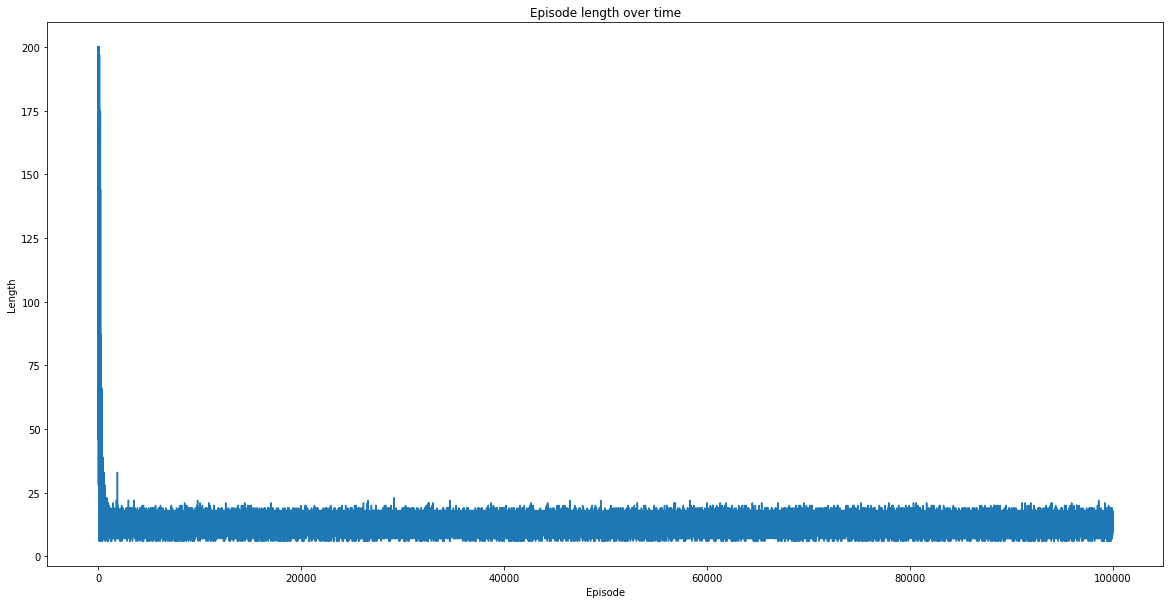

In [400]:
plt.figure(figsize=(20,10))
plt.plot(length_episode_Q)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.show()

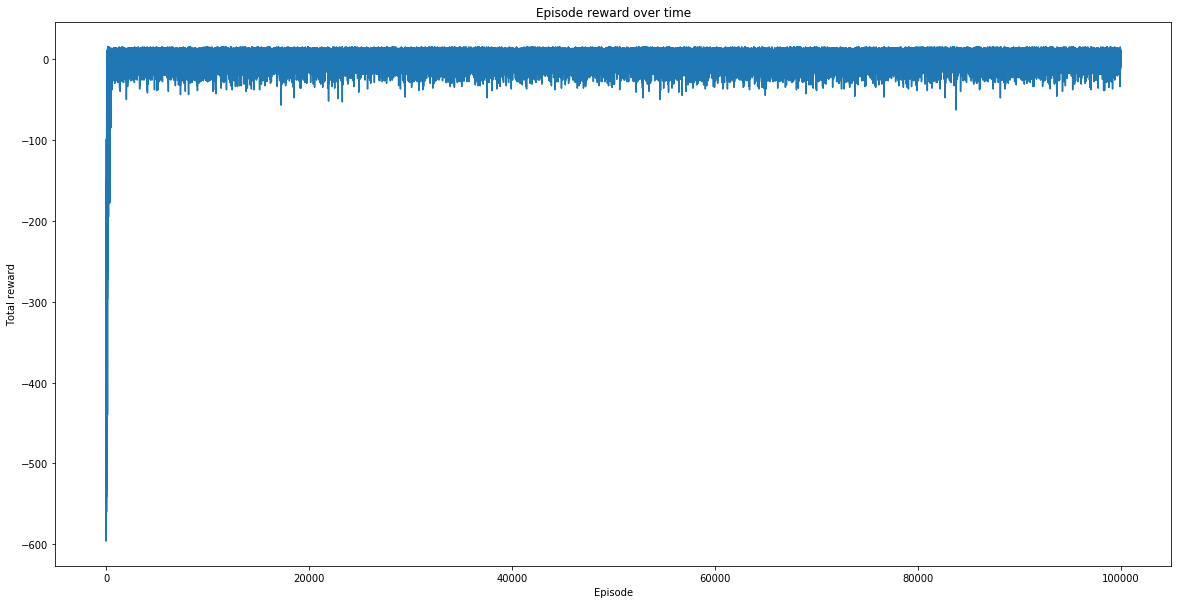

In [412]:
plt.figure(figsize=(20,10))
plt.plot(total_reward_episode_Q)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

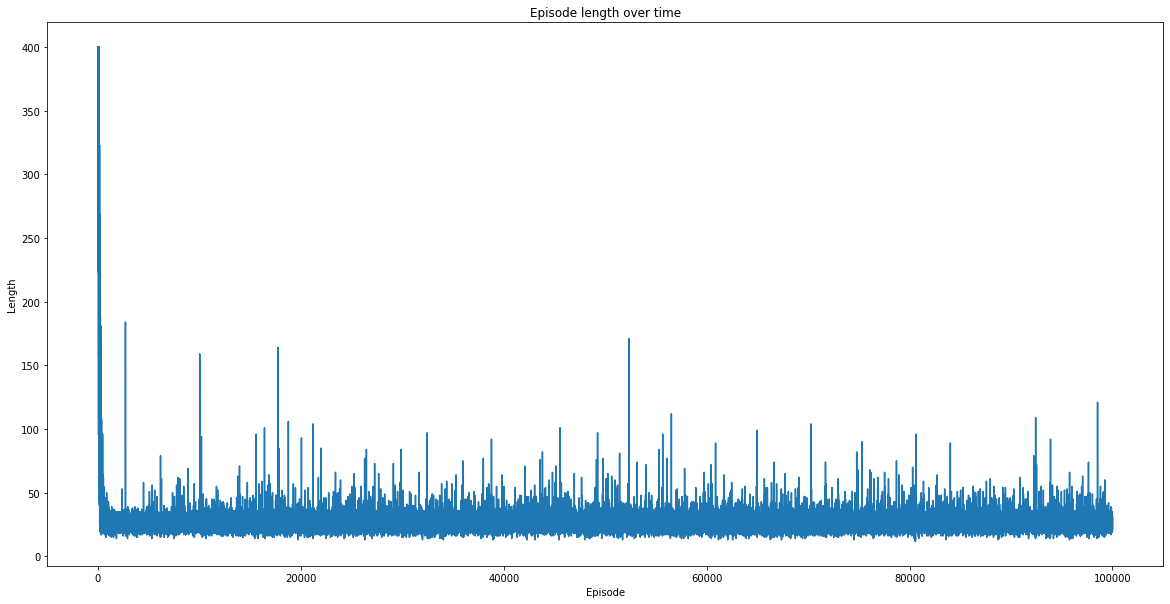

In [410]:
plt.figure(figsize=(20,10))
plt.plot(length_episode_SARSA)
#plt.plot(length_episode_Q)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.show()

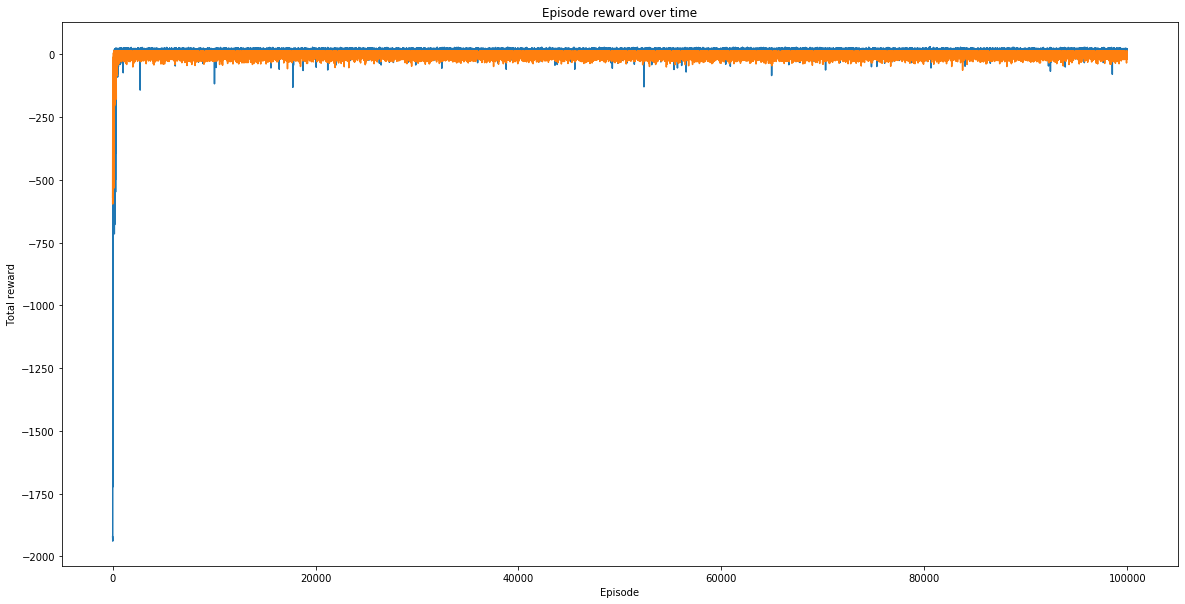

In [414]:
plt.figure(figsize=(20,10))
plt.plot(total_reward_episode_SARSA)
plt.plot(total_reward_episode_Q)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

**TEST BED - (Q Leraning)**



In [372]:
"""Evaluate agent's performance after Q-learning"""



total_epochs_Q = 0
n_episodes = 100
length_episode_Q = [0] * n_episodes
total_reward_episode_Q = [0] * n_episodes
total_penalties_Q = [0] *n_episodes

frames = []

for episode in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        })

        if reward == -10:
            penalties += 10
        elif reward == -1:
            penalties += 1

        epochs += 1

    total_penalties_Q[episode] += penalties
    length_episode_Q[episode] += 1
    total_reward_episode_Q[episode] += reward
    total_epochs_Q += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs_Q / episodes}")
print(f"Average penalties per episode: {sum(total_penalties_Q) / episodes}")
print(f"Average rewards per episode: {sum(total_reward_episode_Q) / episode}")

Results after 100 episodes:
Average timesteps per episode: 13.15
Average penalties per episode: 12.15
Average rewards per episode: 20.2020202020202


In [365]:
print_frames(frames)

+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Timestep: 25
State: 116
Action: 1
Reward: -1


KeyboardInterrupt: ignored

**TEST BED - (SARSA)**

In [382]:
"""Evaluate agent's performance after SARSA"""

total_epochs_SARSA = 0
n_episodes = 100
length_episode_SARSA = [0] * n_episodes
total_reward_episode_SARSA = [0] * n_episodes
total_penalties_SARSA =[0] * n_episodes


frames = []

for episode in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = torch.argmax(optimal_Q[state]).item()
        state, reward, done, info = env.step(action)

        frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        })

        if reward == -10:
            penalties += 10
        elif reward == -1:
            penalties += 1


        epochs += 1

    total_penalties_SARSA[episode] += penalties
    length_episode_SARSA[episode] += 1
    total_reward_episode_SARSA[episode] += reward
    total_epochs_SARSA += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs_SARSA / episodes}")
print(f"Average penalties per episode: {sum(total_penalties_SARSA) / episodes}")
print(f"Average rewards per episode: {sum(total_reward_episode_SARSA) / episode}")

Results after 100 episodes:
Average timesteps per episode: 13.17
Average penalties per episode: 12.17
Average rewards per episode: 20.2020202020202


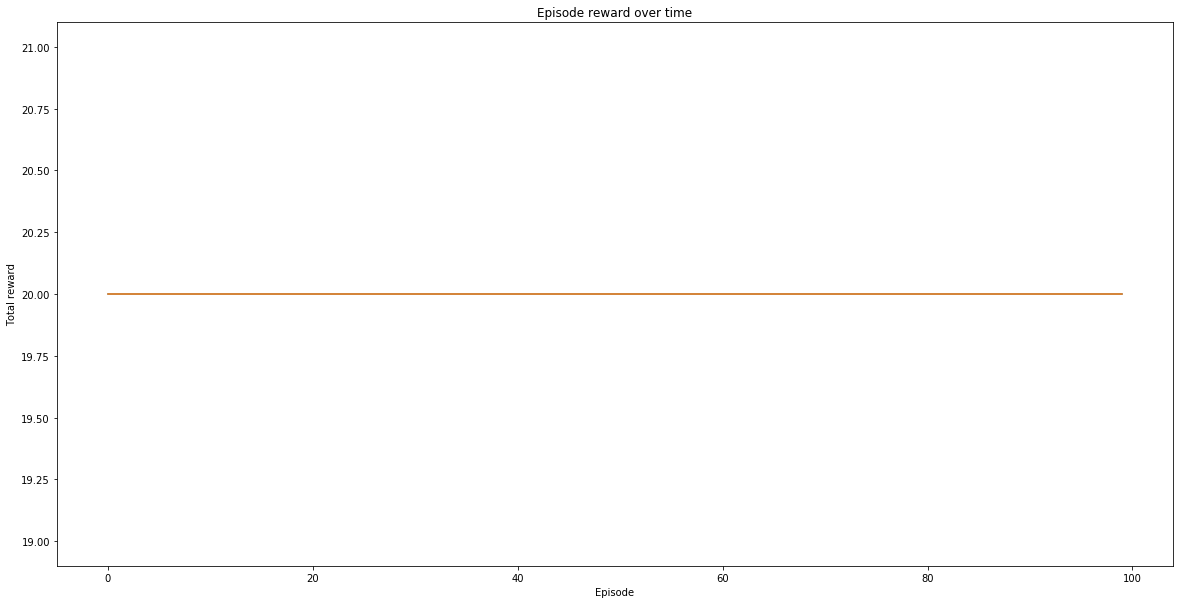

In [383]:
plt.figure(figsize=(20,10))
plt.plot(total_reward_episode_SARSA)
plt.plot(total_reward_episode_Q)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

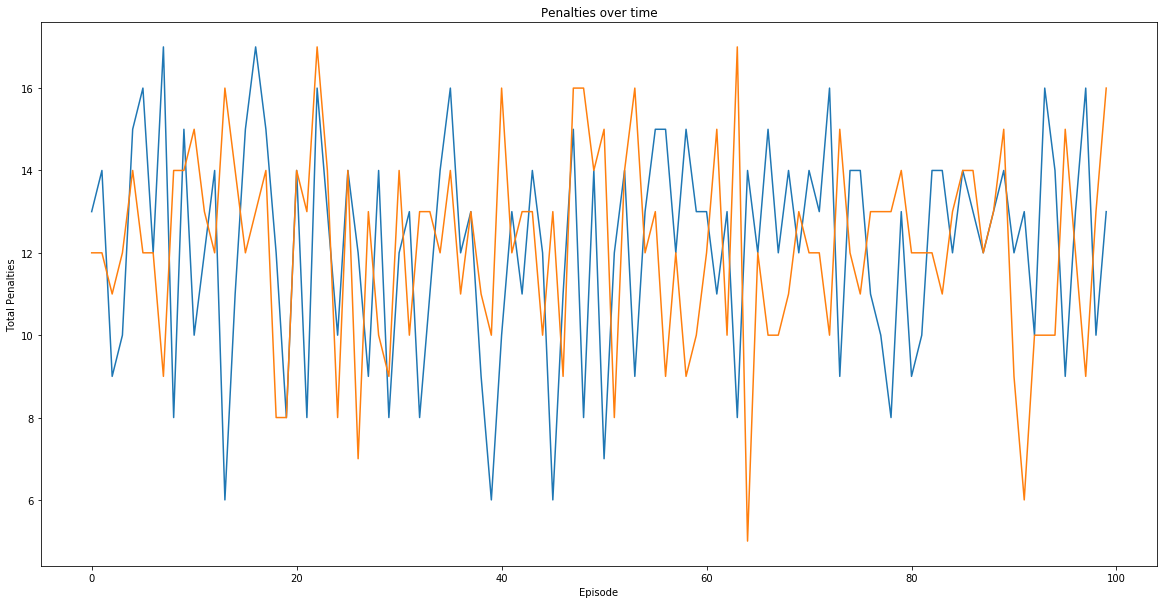

In [384]:
plt.figure(figsize=(20,10))
plt.plot(total_penalties_SARSA)
plt.plot(total_penalties_Q)
plt.title('Penalties over time')
plt.xlabel('Episode')
plt.ylabel('Total Penalties')
plt.show()

In [0]:
print_frames

In [217]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

n_episode = 100000
# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs_SARSA = []
all_penalties_SARSA = []
length_episode_SARSA = [0] * n_episode
total_reward_episode_SARSA = [0] * n_episode

for episode in range(n_episode):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False

    if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
    else:
            action = np.argmax(q_table[state]) # Exploit learned value
    
    while not done:
        
        

        next_state, reward, done, info  = env.step(action)

        if random.uniform(0, 1) < epsilon:
            next_action = env.action_space.sample() # Explore action space
        else:
            next_action = np.argmax(q_table[next_state]) # Exploit learned value
                                   
             
        td_delta = reward + gamma * q_table[next_state][next_action] - q_table[state][action]
                                                
        q_table[state][action] += alpha * td_delta

        if reward == -10:
            penalties += 1     
        
        state = next_state
        action = next_action

        length_episode[episode] += 1
        total_reward_episode[episode] += reward
        epochs += 1
             
            
    
        
    if episode % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {episode}")


Episode: 99900
CPU times: user 2min 40s, sys: 7.3 s, total: 2min 47s
Wall time: 2min 39s


In [1]:
# hi rajiv